# 필수 라이브러리 로딩

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='malgun gothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="malgun gothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

# 2018년도 국내 프로야구 선수 연봉 예측
- 출처 : https://www.statiz.co.kr

## 데이터 불러오기

In [3]:
picher = pd.read_csv('C:/k_digital/source/Machine Learning with Python/picher_stats_2017.csv')
batter = pd.read_csv('C:/k_digital/source/Machine Learning with Python/batter_stats_2017.csv')

## 탐색적 데이터 분석

### 데이터 기본 정보 분석

In [4]:
picher.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   선수명       152 non-null    object 
 1   팀명        152 non-null    object 
 2   승         152 non-null    int64  
 3   패         152 non-null    int64  
 4   세         152 non-null    int64  
 5   홀드        152 non-null    int64  
 6   블론        152 non-null    int64  
 7   경기        152 non-null    int64  
 8   선발        152 non-null    int64  
 9   이닝        152 non-null    float64
 10  삼진/9      152 non-null    float64
 11  볼넷/9      152 non-null    float64
 12  홈런/9      152 non-null    float64
 13  BABIP     152 non-null    float64
 14  LOB%      152 non-null    float64
 15  ERA       152 non-null    float64
 16  RA9-WAR   152 non-null    float64
 17  FIP       152 non-null    float64
 18  kFIP      152 non-null    float64
 19  WAR       152 non-null    float64
 20  연봉(2018)  152 non-null    int64 

In [5]:
picher.head()

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
0,켈리,SK,16,7,0,0,0,30,30,190.0,...,0.76,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000
1,소사,LG,11,11,1,0,0,30,29,185.1,...,0.53,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000
3,차우찬,LG,10,7,0,0,0,28,28,175.2,...,1.02,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000,100000
4,레일리,롯데,13,7,0,0,0,30,30,187.1,...,0.91,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000


In [6]:
picher.shape

(152, 22)

In [8]:
picher['연봉(2018)'].describe()

count       152.000000
mean      18932.236842
std       30940.732924
min        2700.000000
25%        4000.000000
50%        7550.000000
75%       18500.000000
max      230000.000000
Name: 연봉(2018), dtype: float64

<AxesSubplot:>

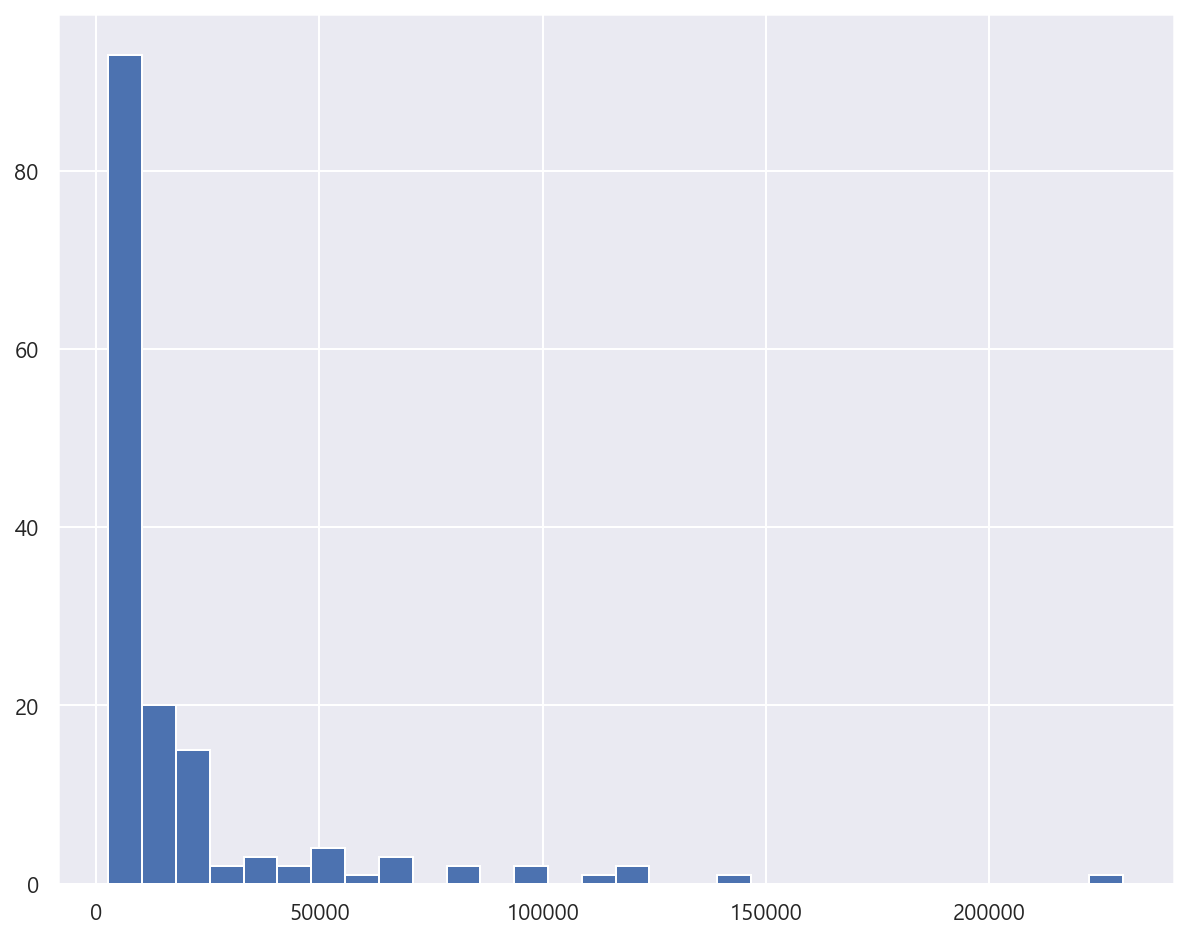

In [11]:
picher['연봉(2018)'].hist(bins=30)

<AxesSubplot:>

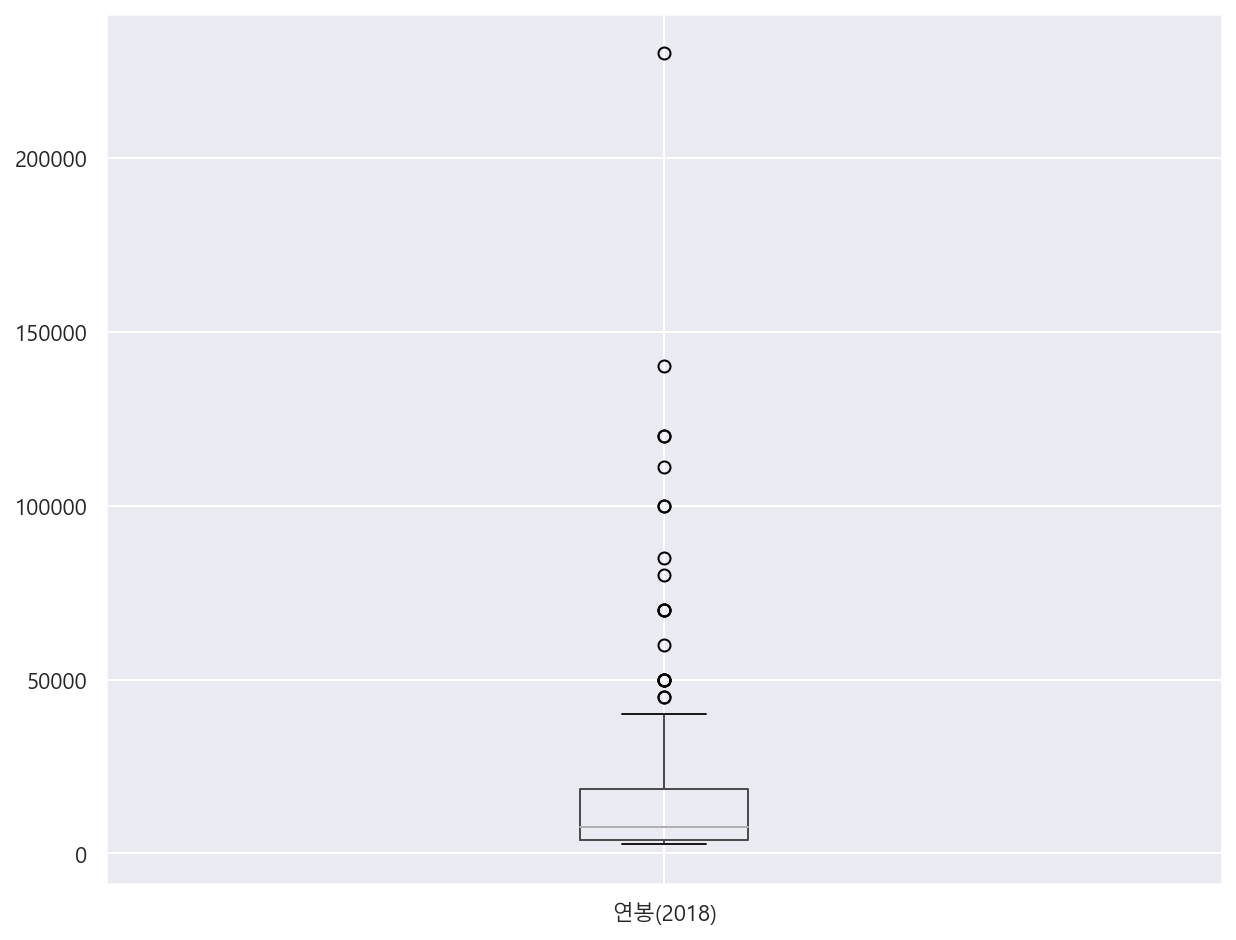

In [13]:
picher.boxplot(column=['연봉(2018)'])

## 회귀분석에 사용할 피처 탐색

In [15]:
picher.columns

Index(['선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)'],
      dtype='object')

In [16]:
picher_df = picher.drop(['선수명', '팀명'], axis=1)
len(picher_df.columns)

20

In [20]:
# 각 feature에 대한 분포를 시각화하는 작업
def plot_hist(df):
    plt.rcParams['figure.figsize'] = [20, 16]
    fig = plt.figure(1)
    
    for i in range(len(df.columns)):
        ax = fig.add_subplot(5, 5, i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
        
    plt.show()

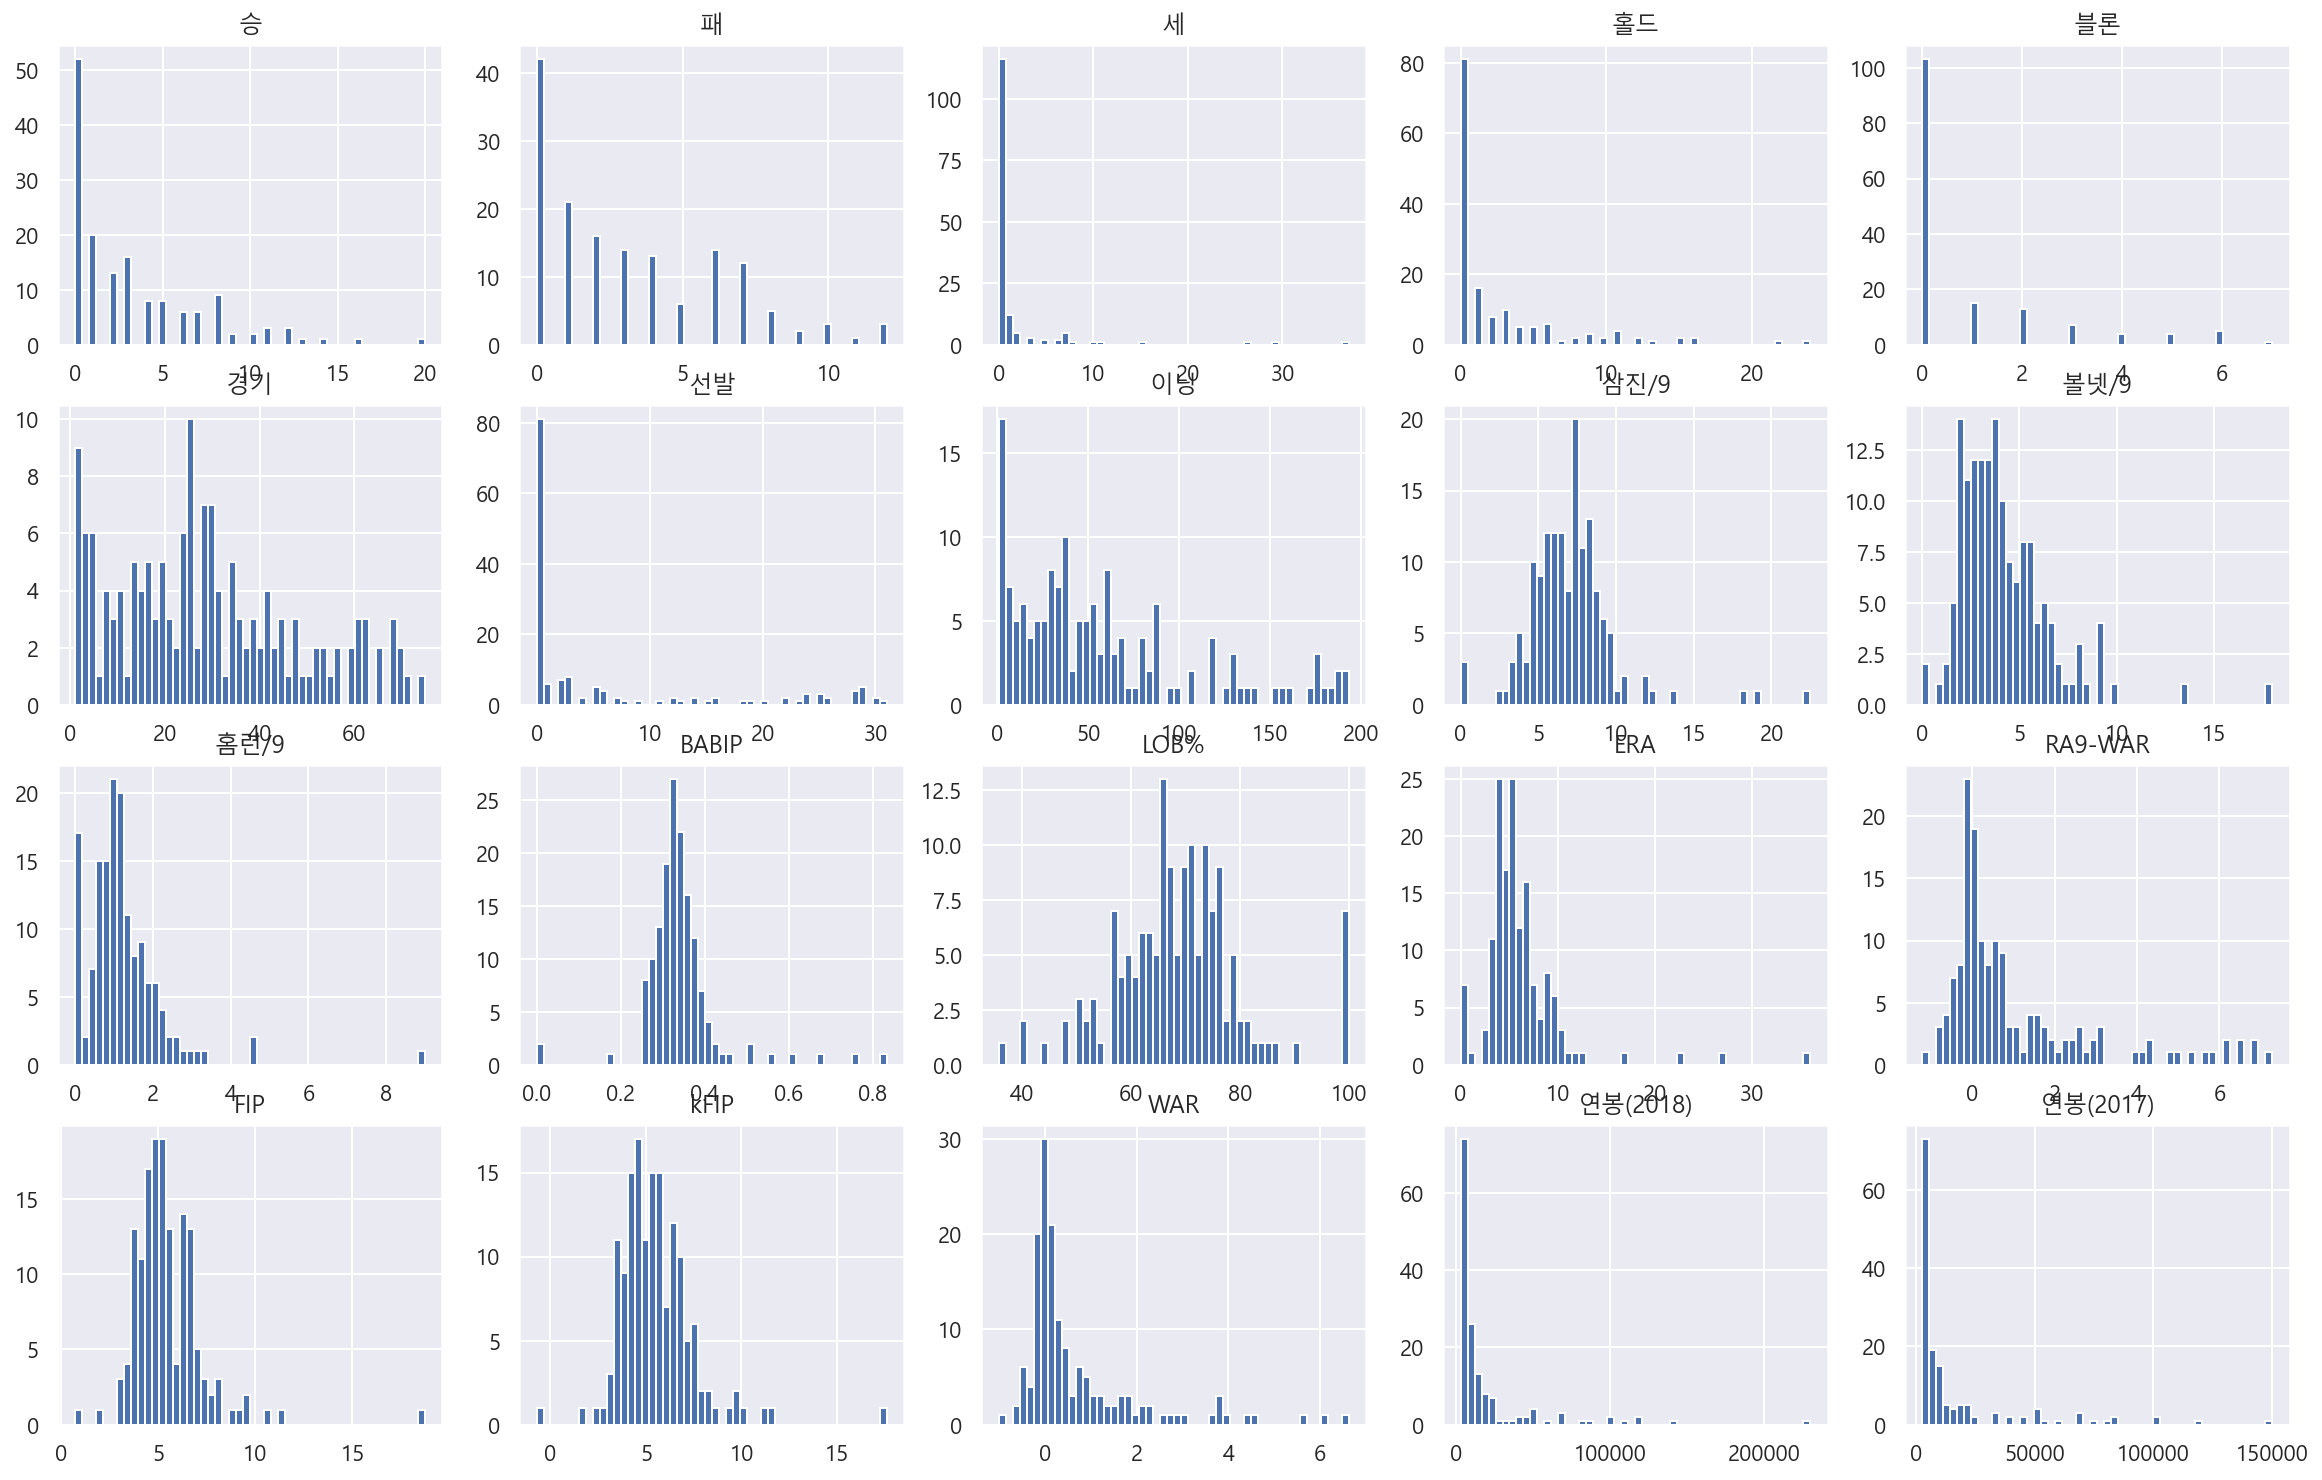

In [21]:
plot_hist(picher_df)

## 전처리 : 피처 스케일링
- 피처 스케일링 : 피처들간의 단위를 맞추는 작업
- StandardScaler : 표준화(평균 = 0. 표준편차 = 1)
- 0에서 1사이의 값으로 단위를 맞추는 작업

In [22]:
def standard_scalling(df, scale_columns):
    
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x : (x-series_mean)/series_std)
        
    return df

In [23]:
# 회귀분석 : 독립변수와 종속변수를 분리하는 작업
# 종속변수 : 연봉(2018)
# 독립변수를 사용할 feature들을 리스트로 저장
scale_columns = ['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
        '연봉(2017)']

picher_df = standard_scalling(picher, scale_columns)

In [24]:
picher_df = picher_df.rename(columns = {'연봉(2018)':'y'})
picher_df.head()

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,y,연봉(2017)
0,켈리,SK,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,...,-0.442382,0.016783,0.446615,-0.587056,3.174630,-0.971030,-1.058125,4.503142,140000,2.734705
1,소사,LG,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,...,-0.668521,-0.241686,-0.122764,-0.519855,3.114968,-1.061888,-1.073265,4.094734,120000,1.337303
2,양현종,KIA,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,...,-0.412886,-0.095595,0.308584,-0.625456,2.973948,-0.837415,-0.866361,3.761956,230000,5.329881
3,차우찬,LG,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,...,-0.186746,-0.477680,0.558765,-0.627856,2.740722,-0.698455,-0.760385,2.998081,100000,3.333592
4,레일리,롯데,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,...,-0.294900,-0.196735,0.481122,-0.539055,2.751570,-0.612941,-0.619085,2.809003,111000,2.734705


### 피처 스케일링 : 더미 or 원-핫 인코딩

- 문자 또는 범주형 데이터를 정형화된 데이터(0과 1)로 변형하는 작업

In [25]:
team_encoding = pd.get_dummies(picher_df['팀명'])
# 기존에 팀명 컬럼 삭제
picher_df = picher_df.drop('팀명', axis = 1)
picher_df = picher_df.join(team_encoding)

In [26]:
team_encoding.head()

,KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0


In [27]:
picher_df.head()

,선수명,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,...,연봉(2017),KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,켈리,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,0.672099,...,2.734705,0,0,0,0,1,0,0,0,0
1,소사,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,0.134531,...,1.337303,0,0,1,0,0,0,0,0,0
2,양현종,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,0.109775,...,5.329881,1,0,0,0,0,0,0,0,0
3,차우찬,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,0.350266,...,3.333592,0,0,1,0,0,0,0,0,0
4,레일리,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,0.155751,...,2.734705,0,0,0,0,0,0,1,0,0


In [35]:
# 성능 평가 함수 
from sklearn.metrics import mean_squared_error, mean_absolute_error

# MAE, AMSE
def evalugte_rger(y, pred):
    #MAE
    mae = mean_absolute_error(y,  pred)
    
    #RMSE
    rmse = np.sqrt(mean_squared_error(y, pred))
    
    print(f'MAE : {mae:.3f}, RMSE : {rmse:.3f}')

## 선형 회귀

### 기본 예측/평가/

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = picher_df[picher_df.columns.difference(['선수명', 'y'])]
y = picher_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

# 평가함수 호출
evalugte_rger(y_test, pred)

MAE : 6208.836, RMSE : 8476.013


In [42]:
def get_top_error_data(y_test, pred, n_tops = 5):
# 예측값, 실제값 데이터 프레임 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_y'])
    result_df['pred_y'] =  np.round(pred)
    result_df['diff'] = np.abs(result_df['real_y']-result_df['pred_y'])

    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops = 10)

    real_y    pred_y     diff
10   35000   11950.0  23050.0
26   29000   46325.0  17325.0
7   100000  116831.0  16831.0
30   16000   30373.0  14373.0
28    9000   -3244.0  12244.0
13   23000   34698.0  11698.0
9    50000   39091.0  10909.0
25    4700   -5447.0  10147.0
24   45000   34979.0  10021.0
12   15000    7892.0   7108.0


In [37]:
import statsmodels.api as sm

model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     47.11
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           5.14e-43
Time:                        10:44:26   Log-Likelihood:                -1267.7
No. Observations:                 121   AIC:                             2591.
Df Residuals:                      93   BIC:                             2670.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
BABIP      -1278.3610   1490.604     -0.858      0.393   -4238.404    1681.682
ERA          -41.4437   2834.935     -0.015      0.988   -5671.062    5588.174
FIP         2.501e+04   1.02e+05      0.245      0.807   -1.78e+05    2.28e+05
KIA         1.943e+04   2943.630      6.602      0.000    1.36e+04    2.53e+04
KT          2.169e+04   2627.850      8.254      0.000    1.65e+04    2.69e+04
LG          2.012e+04   2728.409      7.373      0.000    1.47e+04    2.55e+04
LOB%        -150.2946   1954.733     -0.077      0.939   -4032.008    3731.418
NC          1.873e+04   3361.372      5.571      0.000    1.21e+04    2.54e+04
RA9-WAR     -733.9182   3677.296     -0.200      0.842   -8036.300    6568.463
SK          1.941e+04   2917.036      6.654      0.000    1.36e+04    2.52e+04
WAR         1.185e+04   3150.048      3.761      0.000    5592.994    1.81e+04
kFIP       -2.296e+04   8.69e+04     -0.264      0.792   -1.95e+05     1.5e+05
경기         -2525.3807   3415.415     -0.739      0.462   -9307.719    4256.957
두산          1.496e+04   3520.126      4.249      0.000    7965.822    2.19e+04
롯데          1.698e+04   3186.492      5.327      0.000    1.06e+04    2.33e+04
볼넷/9         865.4701   6502.041      0.133      0.894    -1.2e+04    1.38e+04
블론           139.3558   1498.117      0.093      0.926   -2835.607    3114.319
삼성          1.678e+04   2637.847      6.361      0.000    1.15e+04     2.2e+04
삼진/9       -3376.4964   8305.085     -0.407      0.685   -1.99e+04    1.31e+04
선발         -5592.6158   5915.457     -0.945      0.347   -1.73e+04    6154.310
세           -134.3455   1497.022     -0.090      0.929   -3107.135    2838.444
승           7136.8706   2594.163      2.751      0.007    1985.378    1.23e+04
연봉(2017)    2.147e+04   1491.142     14.396      0.000    1.85e+04    2.44e+04
이닝           673.9514   7378.595      0.091      0.927    -1.4e+04    1.53e+04
패          -1989.4238   2325.044     -0.856      0.394   -6606.501    2627.653
한화          1.995e+04   3017.155      6.612      0.000     1.4e+04    2.59e+04
홀드          -275.2068   1747.739     -0.157      0.875   -3745.871    3195.457
홈런/9       -2215.8740   1.76e+04     -0.126      0.900   -3.72e+04    3.28e+04
==============================================================================
Omnibus:                       29.481   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.748
Skew:                          -0.103   Prob(JB):                     1.00e-69
Kurtosis:                      10.936   Cond. No.                         409.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 피처들의 영향력을 파악하기 위한 시각화 -summary의 params

[Text(0, 0, 'BABIP'),
 Text(1, 0, 'ERA'),
 Text(2, 0, 'FIP'),
 Text(3, 0, 'KIA'),
 Text(4, 0, 'KT'),
 Text(5, 0, 'LG'),
 Text(6, 0, 'LOB%'),
 Text(7, 0, 'NC'),
 Text(8, 0, 'RA9-WAR'),
 Text(9, 0, 'SK'),
 Text(10, 0, 'WAR'),
 Text(11, 0, 'kFIP'),
 Text(12, 0, '경기'),
 Text(13, 0, '두산'),
 Text(14, 0, '롯데'),
 Text(15, 0, '볼넷/9'),
 Text(16, 0, '블론'),
 Text(17, 0, '삼성'),
 Text(18, 0, '삼진/9'),
 Text(19, 0, '선발'),
 Text(20, 0, '세'),
 Text(21, 0, '승'),
 Text(22, 0, '연봉(2017)'),
 Text(23, 0, '이닝'),
 Text(24, 0, '패'),
 Text(25, 0, '한화'),
 Text(26, 0, '홀드'),
 Text(27, 0, '홈런/9')]

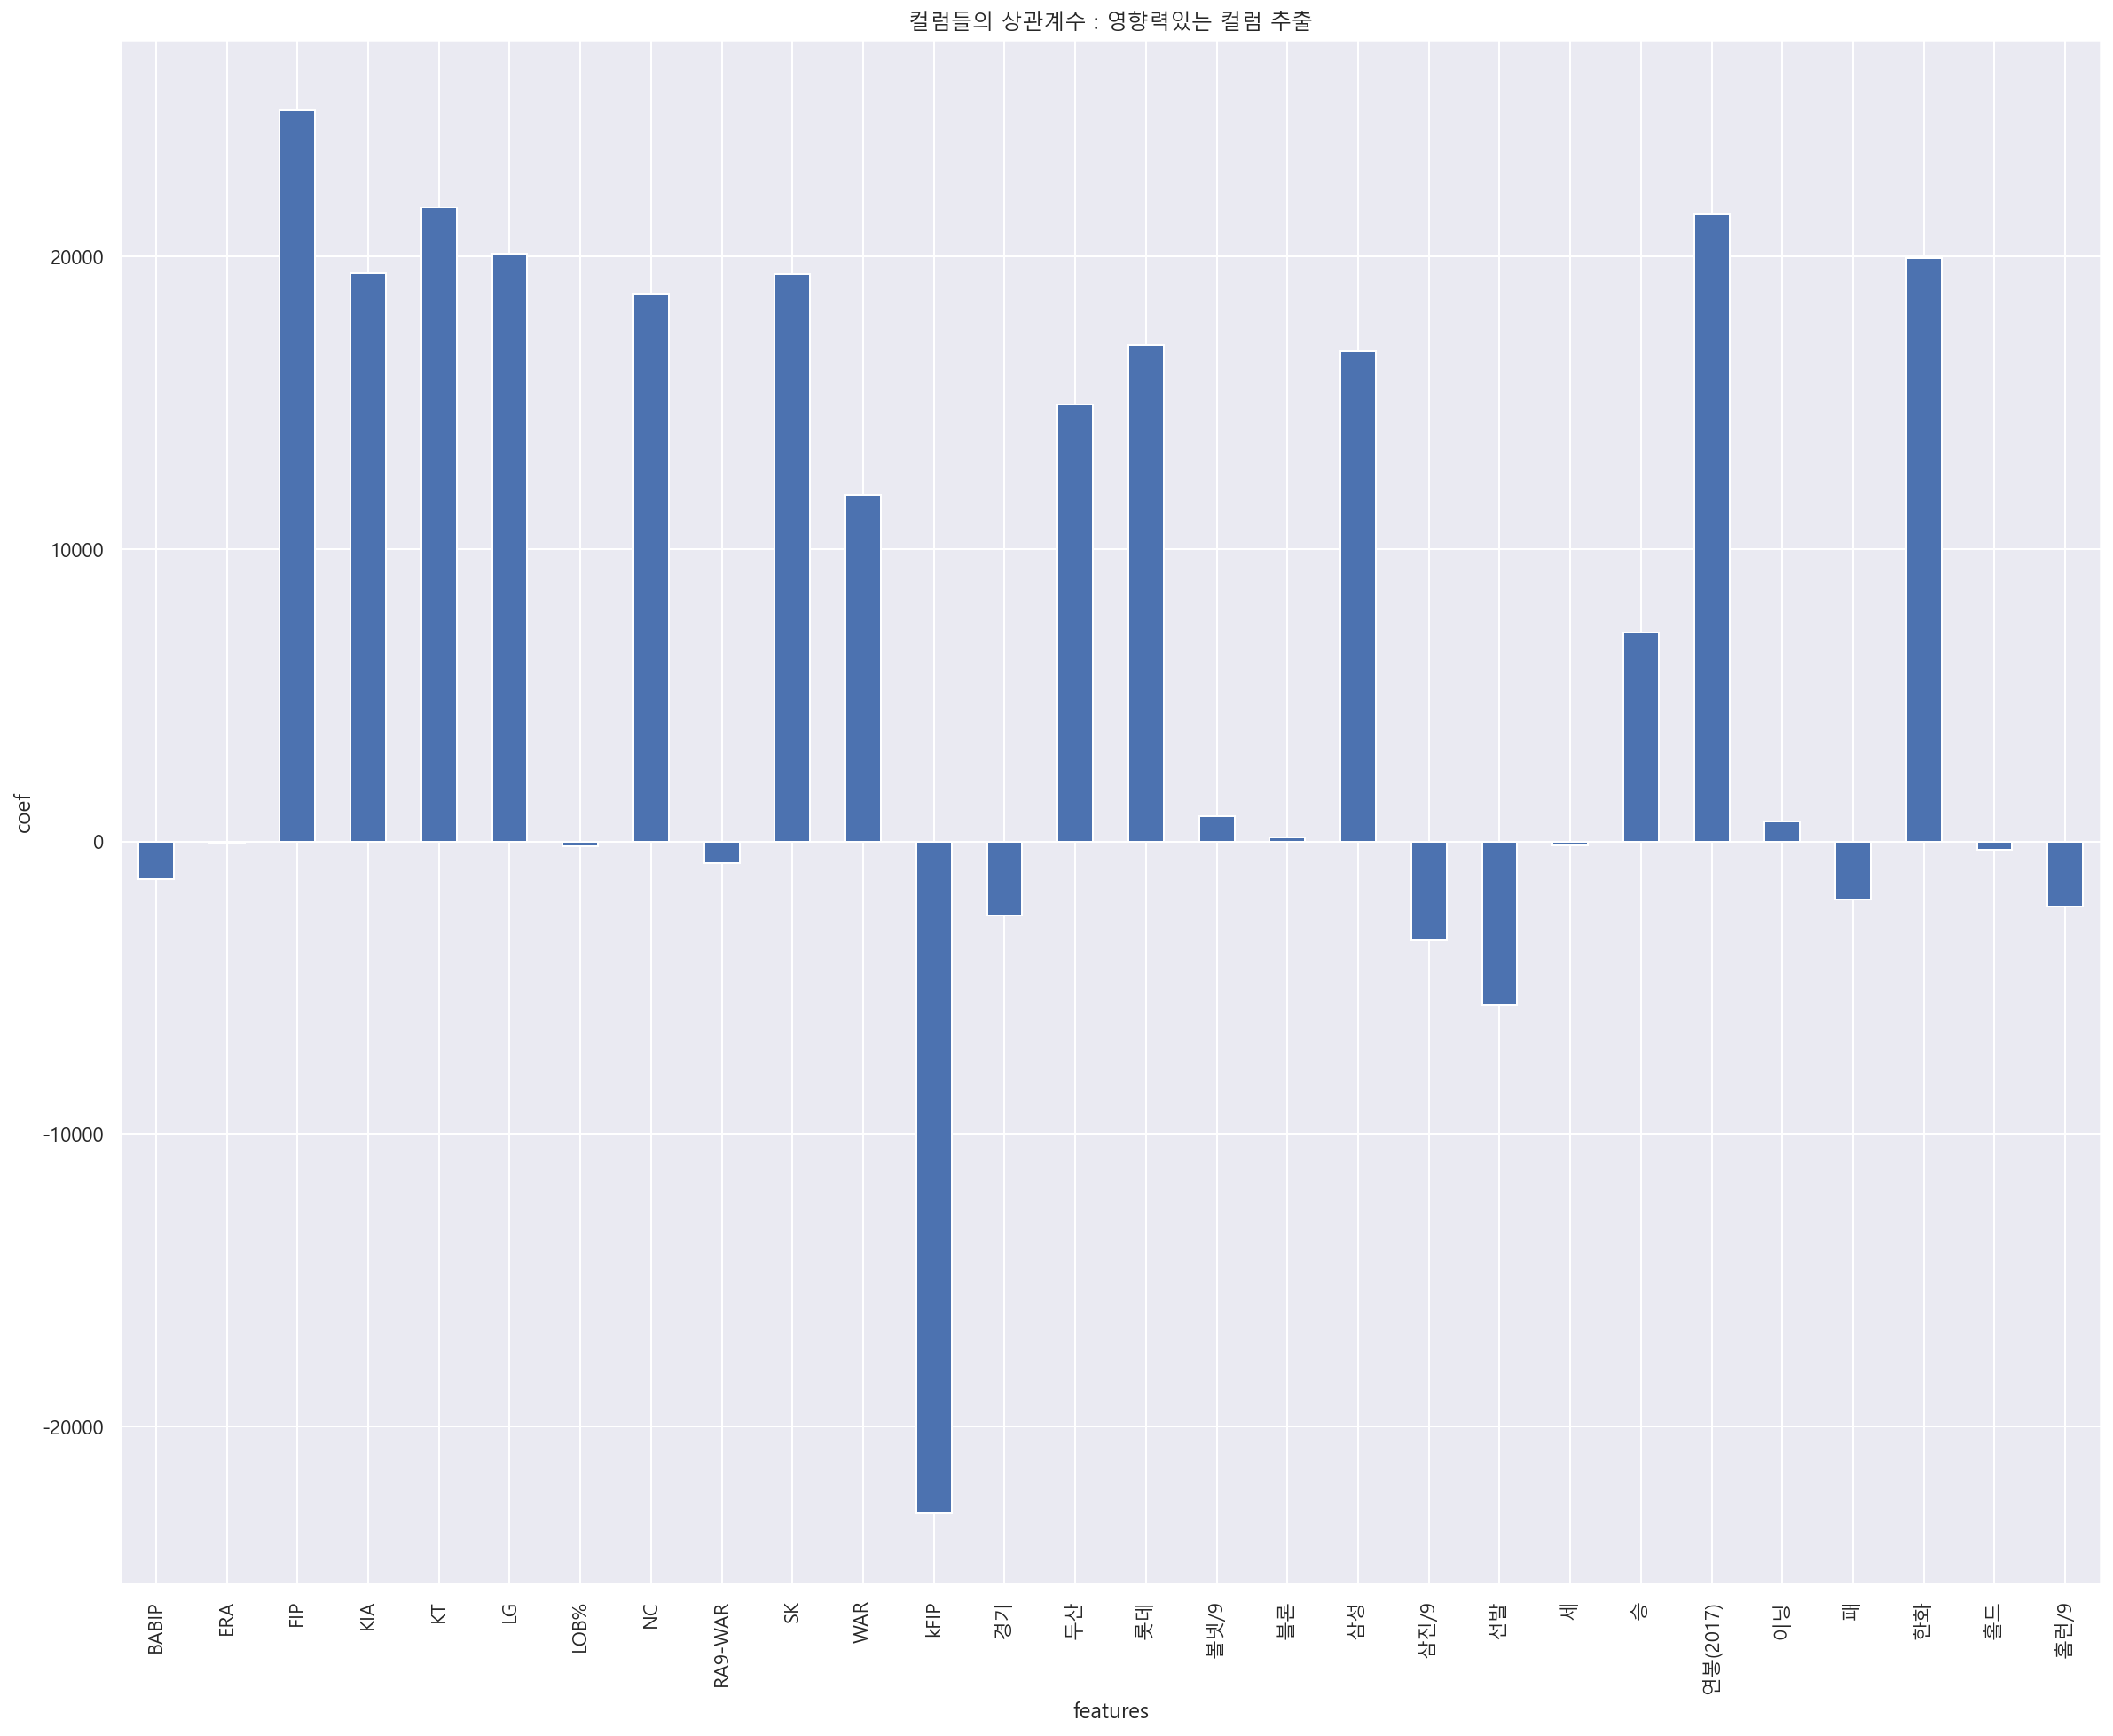

In [39]:
# 회귀계수를 리스트로 변환하는 작업
coefs = model.params.tolist()
coefs_series = pd.Series(coefs)

# 변수명(index)를 리스트로 변환하는 작업
x_labels = model.params.index.tolist()

ax = coefs_series.plot(kind = 'bar')
ax.set_title('컬럼들의 상관계수 : 영향력있는 컬럼 추출')
ax.set_xlabel('features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)

## 피처들의 상관관계를 분석하는 시각화 -Heatmap

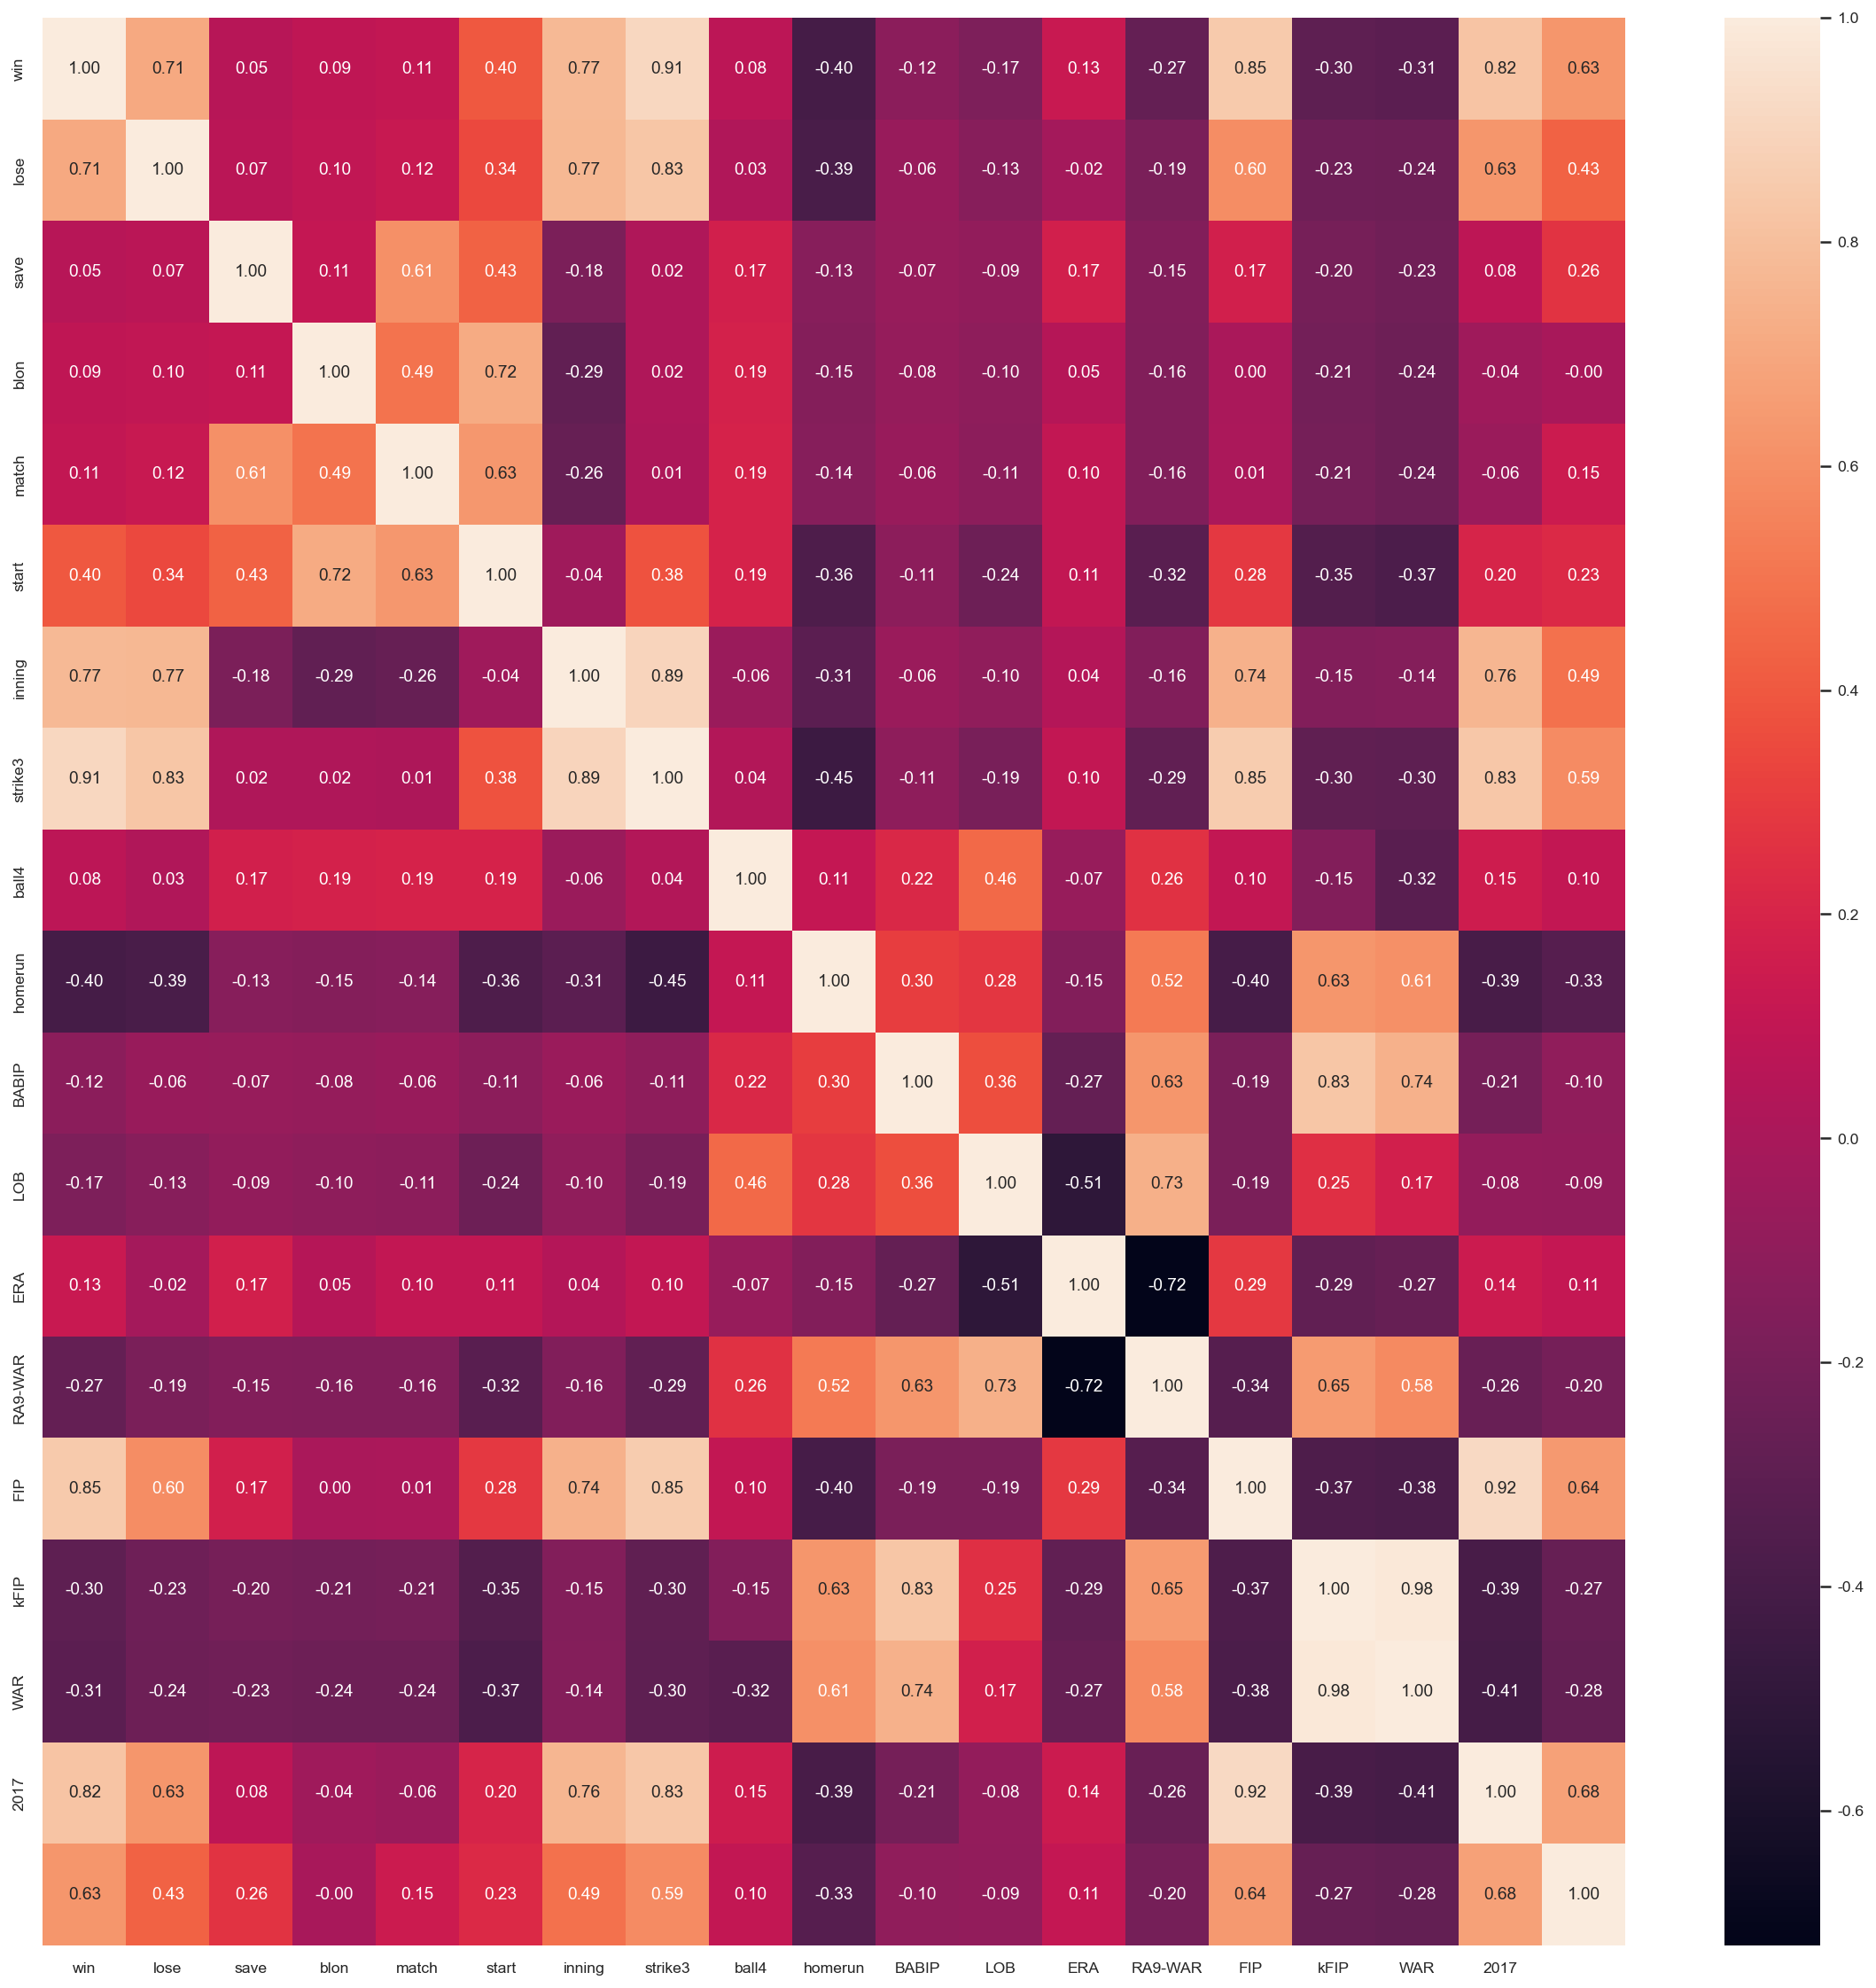

In [43]:
# 피처들의 상관계수 산출하기
corr = picher_df[scale_columns].corr(method='pearson')
show_cols = ['win', 'lose', 'save', 'blon', 'match', 'start', 'inning', 'strike3',
             'ball4', 'homerun', 'BABIP', 'LOB', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
        '2017']

# 히트맵
plt.figure(figsize =(20, 20))
sns.set(font_scale=0.8)
sns.heatmap(corr.values, annot=True, cbar=True,
           fmt='.2f', xticklabels = show_cols, yticklabels=show_cols)
plt.show()

## 회귀 분석의 성능을 향상시키기 위해 다중 공산성 확인


In [45]:
# 분산 팽창 요일(VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 피처들의 vir 계수 확인
vif = pd.DataFrame()
vif['VIF factor']=[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif.round(1)

,VIF factor,features
0,3.2,BABIP
1,10.6,ERA
2,14238.3,FIP
3,1.1,KIA
4,1.1,KT
5,1.1,LG
6,4.3,LOB%
7,1.1,NC
8,13.6,RA9-WAR
9,1.1,SK


## 적절한 피처를 이용하여 다시 모델 학습

In [51]:
x = picher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '선발', '연봉(2017)']]
y = picher_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

# 평가함수 호출
evalugte_rger(y_test, pred)

MAE : 6208.836, RMSE : 8476.013


In [52]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

AttributeError: 'OLSResults' object has no attribute 'score'